In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate

## System of Equations

The equations of structure of an compact object with spherical symmetry (neutron stars in our case) is given by (in units where $c=G=1$):

$$ P=P(\rho), $$
$$ \frac{dm}{dr}=4\pi \rho r^2 , $$
$$ \frac{dP}{dr}=-(\rho+P)\frac{m+4\pi r^3 P}{r(r-2m)} , $$

and if is required


$$ \frac{d\nu}{dr}= \frac{m+4\pi r^3 P}{r(r-2m)} .$$


Nondimensionalizing the variables:


$r=b\bar{r} \quad ; \quad \rho=\Sigma \bar{\rho} \quad ; \quad m=m_*\bar{m} \quad ; \quad  P=P_* \bar{P}$ 

with $\Sigma=\Sigma(m_n)$.

So if we want just one parameter ($m_n$), given $\Sigma$, the other parameters $b$, $m_*$, $P_*$ are found by forcing the nondimensional equation to keep the same form:

$$ b=\frac{1}{\sqrt{\Sigma}} \quad ; \quad m_*=b \quad ; \quad P_*=\Sigma.$$

With a particular choice of $\Sigma$ and fixing the units with factors of $c$ and $G$ we have:


$$ \Sigma=\frac{m_{n}^{4}c^{3}}{8 \pi^2 \hbar^3}\quad;\quad b=\frac{c}{\sqrt{\Sigma G}}\quad, \quad m= \frac{b c^2}{G} \bar{m} \quad; \quad P= \Sigma c^2 \bar{P},$$

and the nondimensional system of equations keeps the same form:

$$ \bar{P}=\bar{P}(\bar{\rho}), $$
$$ \frac{d\bar{m}}{\bar{dr}}=4\pi \bar{\rho} \bar{r}^2 , $$
$$ \frac{d\bar{P}}{d\bar{r}}=-(\bar{\rho}+\bar{P})\frac{\bar{m}+4\pi \bar{r}^3 \bar{P}}{\bar{r}(\bar{r}-2\bar{m})} . $$

## Solving the system

To solve this system of equations we need two initial conditions:

$$ \bar{P}{(0)}=P_{c}{(\bar{\rho_{c}})} \quad ; \quad \bar{m}{(0)}=0,$$

depending on the choice of $\rho_{c}$.

We want our equation of state to be a table of numbers $(\rho_{i},P_{i})$, this equation of state will depend on the theoretical model used to study the interior of the neutron star.

Loading some constants (in cgs units) from a separeted file and declaring the parameters that carry the dimensions

In [2]:
import Physical_Const as phys
h=phys.h 
c=phys.c
G=phys.G
Msun=phys.Msun
mn=phys.mn # Neutron mass


Sigma=mn**4.0*c**3.0/(8.0*np.pi**2*(h/(2.0*np.pi))**3.0) #Dimensions of energy density
b=c/np.sqrt(Sigma*G) # Dimensions of radius
mdim=b*c**2.0/G # Dimensions of mass
pdim=Sigma*c**2 # Dimensions of pressure

loading the equation of state and interpolating it linearly

In [3]:
rhoSLy,PSLy=np.loadtxt('EOS/sly.dat',usecols=(2,1),unpack=True)
#P_SLy=interpolate.interp1d(rhoSLy/Sigma,(PSLy*c**2)/pdim)
#rho_SLy=interpolate.interp1d((PSLy*c**2)/pdim,rhoSLy/Sigma)
# Interpolating P

def P_EoS(r):
    pp=interpolate.interp1d(rhoSLy/Sigma,(PSLy*c**2)/pdim,kind='cubic')
    return pp(r)


# Interpolating Rho

def rho_EoS(r):
    rhorho=interpolate.interp1d((PSLy*c**2)/pdim,rhoSLy/Sigma,kind='cubic')
    return rhorho(r)


Comparing the table and the interpolation

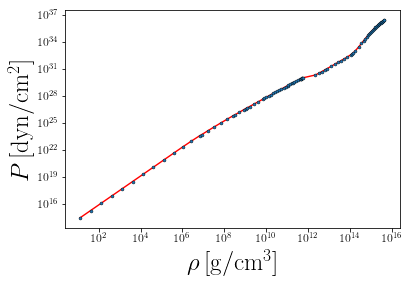

In [4]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)


fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)


plt.loglog(rhoSLy,P_EoS(rhoSLy/Sigma)*pdim,color='red',linewidth=1.4, \
           label="Interpolation") # Interpolación
plt.loglog(rhoSLy,PSLy*c**2,marker='o',markersize=3,label='Data',\
           markeredgecolor='black',markeredgewidth=0.4,linestyle='') # Valores de la tabla
plt.xlabel(r'$\rho\,\rm{[g/cm^3]}$')
plt.ylabel(r'$P\,\rm{[dyn/cm^{2}]}$')
plt.savefig('SLyEoS.pdf',format='pdf',dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

With the equation of state interpolated we can declare the system of equations:

In [5]:
def TOV(r,y):
    mns, pns, nuns = y
    #print(r)
    dmdr=4.0*np.pi*r**2.0*rho_EoS(pns)
    dnudr=(4.0*np.pi*r**3.0*pns+mns)/(r*(r-2.0*mns))
    dpdr=-dnudr*(pns+rho_EoS(pns))
    return [dmdr,dpdr,dnudr]

# Stellar structure

Setting up the integration routine

In [6]:
def StaticSeq(y0,r0,dr):
    """  """
    Static=integrate.ode(TOV).set_integrator('dopri5',atol=1e-9) # Dopri (Dorman-Prince method) is a R-K method of order (4)5
    Static.set_initial_value(y0,r0)
    ms=[]; ps=[];rs=[]; rhos=[]
    ms.append(y0[0]); ps.append(y0[1]); rhos.append(rho_EoS(y0[1])); rs.append(r0) 
    while Static.successful() and rho_EoS(Static.y[1])*Sigma>1e8 and Static.y[1]>0:
        Static.integrate(Static.t+dr)
        ms.append(Static.y[0]); ps.append(Static.y[1]); rhos.append(rho_EoS(Static.y[1])); rs.append(Static.t)  
    while Static.successful() and rho_EoS(Static.y[1])*Sigma>1e6 and Static.y[1]>0:
        Static.integrate(Static.t+dr/10.0)
        ms.append(Static.y[0]); ps.append(Static.y[1]); rhos.append(rho_EoS(Static.y[1])); rs.append(Static.t)
    while Static.successful() and rho_EoS(Static.y[1])*Sigma>1e4 and Static.y[1]>0:
        Static.integrate(Static.t+dr/100.0)
        ms.append(Static.y[0]); ps.append(Static.y[1]); rhos.append(rho_EoS(Static.y[1])); rs.append(Static.t)
    while Static.successful() and rho_EoS(Static.y[1])*Sigma>1e2 and Static.y[1]>0:
        Static.integrate(Static.t+dr/1000.0)
        ms.append(Static.y[0]); ps.append(Static.y[1]); rhos.append(rho_EoS(Static.y[1])); rs.append(Static.t)
    while Static.successful() and rho_EoS(Static.y[1])*Sigma>14.0 and Static.y[1]>0:
        Static.integrate(Static.t+dr/1e+5)
        ms.append(Static.y[0]); ps.append(Static.y[1]); rhos.append(rho_EoS(Static.y[1])); rs.append(Static.t)
    return np.array([ms,ps,rhos,rs]) 
    # Returns arrays of m(r) in solar masses, P(r) and Rho(r) in cgs, and r in km

In [7]:
pdim

2.0499091631194222e+36

# Chossing an specific model

In [8]:
rho_0=10.0**15
P_0=P_EoS(rho_0/Sigma)

In [9]:
m1,p1,rho1,r1=StaticSeq([0,P_0,0],1e-7,1e-4)

## Density profile

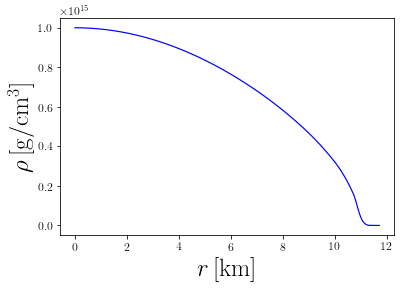

In [32]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(r1*b*1e-5,rho1*Sigma,color='blue',linewidth='1.2') 
#plt.yscale('log')
plt.xlabel(r'$r\,\rm{[km]}$')
plt.ylabel(r'$\rho\,\rm{[g/cm^3]}$')
plt.savefig('DProf_SLy.pdf', format='pdf', dpi=1000,bbox_inches="tight")
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()

## Pressure profile

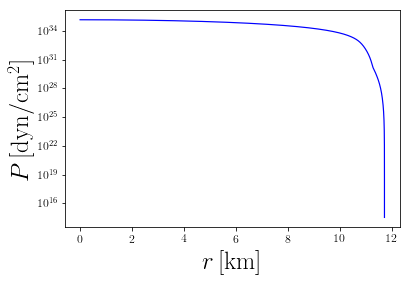

In [11]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(r1*b*1e-5,p1*pdim,'b-', linewidth=1.2) 
plt.yscale('log')
plt.xlabel(r'$r\,\rm{[km]}$')
plt.ylabel(r'$P\,\rm{[dyn/cm^2]}$')
plt.savefig('PProf_SLy.pdf', format='pdf', dpi=1000,bbox_inches="tight")
plt.show()
plt.clf()

# Stability against convection

In [12]:
rhoprof=interpolate.interp1d(r1,rho1,kind='cubic')

In [13]:
rhoprof(r1[0])

array(1.e+15)

## Finding derivatives (very bad)

Probando la librería del proyecto findiff (https://github.com/maroba/findiff).

In [31]:
from findiff import FinDiff

In [32]:
d2_dr2=FinDiff(0, r1, 2,acc=20)
d2rho_dr2=d2_dr2(rho1)

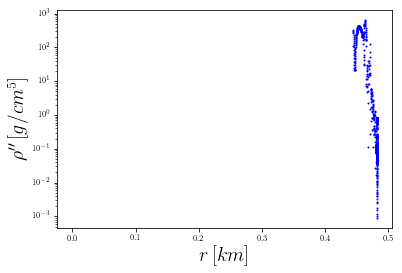

In [33]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(r1,d2rho_dr2,'bo', markersize=1) 
plt.yscale('log')
plt.xlabel(r'$r\,[km]$')
plt.ylabel(r'$\rho^{\prime\prime}\,[g/cm^5]$')
plt.savefig('ddSLy.png', format='png', dpi=1000)
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()

### Probando con una interpolación antes de derivar

In [85]:
k=5 #orden del spline
n=len(r1) #número de puntos
s=0.001 #factor de suavizamiento
rhos=interpolate.UnivariateSpline(r1, rho1, k=k, s=s)
drho=interpolate.UnivariateSpline(r1, rho1, k=k, s=s).derivative(n=1)
ddrho=interpolate.UnivariateSpline(r1, rho1, k=k, s=s).derivative(n=2)

In [86]:
ddrho(r1)

array([ -2.97915949,  -2.98048776,  -2.9818137 , ..., 150.6757819 ,
       150.67585024, 150.67591859])

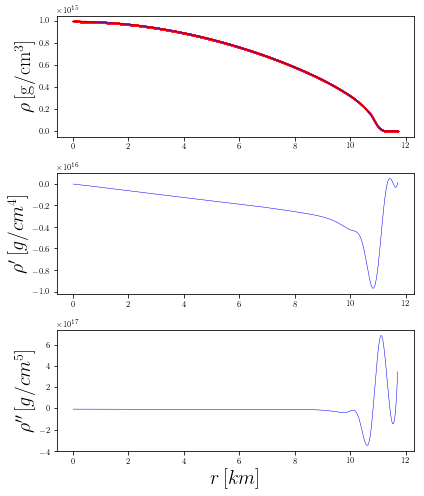

In [87]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure(figsize=[6.4,8])

plt.subplot(311)
plt.plot(r1*b*1e-5,rho1*Sigma,color='red',marker='o',markersize='0.4') 
plt.plot(r1*b*1e-5,rhos(r1)*Sigma,color='blue',linewidth='0.5') 
#plt.yscale('log')
#plt.xlabel(r'$r\,\rm{[km]}$')
plt.ylabel(r'$\rho\,\rm{[g/cm^3]}$')

plt.subplot(312)
plt.plot(r1*b*1e-5,drho(r1)*Sigma,'b-', linewidth=0.5) 
#plt.yscale('log')
#plt.xlabel(r'$r\,[km]$')
plt.ylabel(r'$\rho^{\prime}\,[g/cm^4]$')

plt.subplot(313)
plt.plot(r1*b*1e-5,ddrho(r1)*Sigma,'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}\,[g/cm^5]$')
plt.xlabel(r'$r\,[km]$')

fig.subplots_adjust(hspace=0.3)

plt.savefig('ddsSLy.pdf', format='pdf', dpi=1000)
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()

Zooming in to check the behaviour at the start

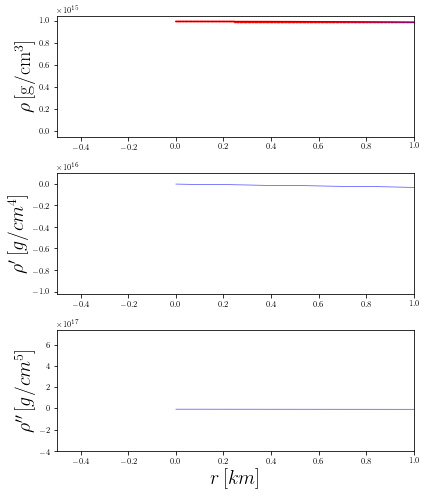

In [88]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure(figsize=[6.4,8])


plt.subplot(311)
plt.plot(r1*b*1e-5,rho1*Sigma,color='red',marker='o',markersize='0.4') 
plt.plot(r1*b*1e-5,rhos(r1)*Sigma,color='blue',linewidth='0.5') 
#plt.yscale('log')
#plt.xlabel(r'$r\,\rm{[km]}$')
plt.ylabel(r'$\rho\,\rm{[g/cm^3]}$')
plt.xlim([-0.5,1])

plt.subplot(312)
plt.plot(r1*b*1e-5,drho(r1)*Sigma,'b-', linewidth=0.5) 
#plt.yscale('log')
#plt.xlabel(r'$r\,[km]$')
plt.ylabel(r'$\rho^{\prime}\,[g/cm^4]$')
plt.xlim([-0.5,1])

plt.subplot(313)
plt.plot(r1*b*1e-5,ddrho(r1)*Sigma,'b-', linewidth=0.5) 
plt.ylabel(r'$\rho^{\prime\prime}\,[g/cm^5]$')
plt.xlabel(r'$r\,[km]$')
plt.xlim([-0.5,1])

fig.subplots_adjust(hspace=0.3)

plt.savefig('ddsSLyZoom1.pdf', format='pdf', dpi=1000)
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()

The spline is smoothing the data too much

# M-R and M-$\rho_c$

The same integration routine (without saving the arrays)

In [54]:
def StaticSeqMR(y0,r0,dr):
    Static=integrate.ode(TOV).set_integrator('dopri5',atol=1e-5) # Dopri (Dorman-Prince method) is a R-K method of order (4)5
    Static.set_initial_value(y0,r0)
    while Static.successful() and rho_EoS(Static.y[1])*Sigma>1e8 and Static.y[1]>0:
        Static.integrate(Static.t+dr)
    while Static.successful() and rho_EoS(Static.y[1])*Sigma>1e6 and Static.y[1]>0:
        Static.integrate(Static.t+dr/10.0)
    while Static.successful() and rho_EoS(Static.y[1])*Sigma>1e4 and Static.y[1]>0:
        Static.integrate(Static.t+dr/100.0)
    while Static.successful() and rho_EoS(Static.y[1])*Sigma>1e2 and Static.y[1]>0:
        Static.integrate(Static.t+dr/1000.0)
    while Static.successful() and rho_EoS(Static.y[1])*Sigma>14.0 and Static.y[1]>0:
        Static.integrate(Static.t+dr/5e+5)
    mstar=Static.y[0]
    rstar=Static.t
    nustar=np.log(1-2.0*Static.y[0]/Static.t)-Static.y[2]  
    return [mstar*mdim/Msun,rstar*b*1e-5,rho_EoS(y0[1])*Sigma] 
    # Returns mass of the star in solar masses, radius of the star in km and rho_c in cgs

We choose the values for $\rho_c$ we want to consider and integrate from $r0$ every $dr$ saving the different values of $M_{star}$, $R_{star}$ and $\rho_c$ (slow):

In [55]:
#Range of central densities and central pressures (they depend on how high the EOS go)
n=np.arange(14.5,15.5,0.05)
rhosc=10.0**n 
psc=P_EoS(rhosc/Sigma) 

In [56]:
#Initial values
dr=1e-4 # Step size
r0=dr/10.0 # Initial point
m0=0 
nu0=0

In [57]:
StaticSeqMR([m0,psc[0],nu0],r0,dr)

[0.21878858907105728, 15.33715050043264, 317084770210761.8]

In [58]:
MM=[];RR=[];rhorho=[]

for pc in psc:
    MRrho=StaticSeqMR([m0,pc,nu0],r0,dr)
   # print(MRrho)
    RR=RR+[MRrho[1]]
    MM=MM+[MRrho[0]]
    rhorho=rhorho+[MRrho[2]]

ValueError: A value in x_new is below the interpolation range.

In [59]:
rhorho

[317084770210761.8,
 354541796851761.56,
 397897634701508.5,
 446821049762795.75,
 501346355204914.56,
 562303450713041.44,
 630988319258063.4,
 707945119342047.4,
 794330974551833.6,
 891260972564100.2,
 999999598920593.2,
 1122017457057163.0,
 1258932994747192.8,
 1412538446418402.2]

In [60]:
rhosc

array([3.16227766e+14, 3.54813389e+14, 3.98107171e+14, 4.46683592e+14,
       5.01187234e+14, 5.62341325e+14, 6.30957344e+14, 7.07945784e+14,
       7.94328235e+14, 8.91250938e+14, 1.00000000e+15, 1.12201845e+15,
       1.25892541e+15, 1.41253754e+15, 1.58489319e+15, 1.77827941e+15,
       1.99526231e+15, 2.23872114e+15, 2.51188643e+15, 2.81838293e+15])

### Mass-Radius Relation

Plotting the M-R relation

In [ ]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(RR, MM,'b-', linewidth=1.2) 
plt.xlabel(r'$R\,[km]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.savefig('MRrel_NL3.png', format='png', dpi=1000)
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()

### Mass-Central Density Relation

Plotting the M-$\rho_c$ relation

In [ ]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(rhorho, MM,'b-', linewidth=1.2)
plt.xscale('log')
plt.xlabel(r'$\rho_c\,[g/cm^{3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.savefig('Mrhorel_NL3.png', format='png', dpi=1000)
#plt.savefig('MRrhorel_NL3.eps')
plt.show()
plt.clf()